In [1]:
import os
import gc
import re
import sys
import time
import json
import random
import datetime
import traceback
import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
open_category = pd.read_csv('../tmp/train/open_category.csv')
brand = open_category.loc[(open_category['parent'].isnull()),:]
brand = brand.loc[:, ['name','slug','brand_area']].rename(columns={'name':'brand_name','slug':'brand_slug'})

open_category = open_category.loc[(open_category['parent'].notnull()),:]
open_category = open_category.rename(columns={'slug':'global_slug','parent':'brand_slug','name':'global_name'})
open_category = open_category.loc[:,['brand_slug','global_slug','global_name']]
open_category = open_category.merge(brand, how='left', on=['brand_slug'])
open_model_detail = pd.read_csv('../tmp/train/open_model_detail.csv')
open_model_detail = open_model_detail.merge(open_category, how='left', on=['global_slug'])
open_model_detail = open_model_detail.loc[:, ['brand_name','global_name','detail_model','model_detail_slug','year',
                                             'volume','control','emission_standard','brand_area']]
open_model_detail = open_model_detail.rename(columns={'year':'online_year'})

car_source = pd.read_csv('../tmp/train/car_source.csv')
car_source = car_source.loc[(car_source['domain'].isin(['guazi.com','renrenche.com']))&(car_source['model_detail_slug'].notnull()), :]
car_source.reset_index(inplace=True, drop=True)
car_source = car_source.merge(open_model_detail, how='left', on=['model_detail_slug'])
car_source = car_source.drop(['popularity','expired_at','sold_time','source_type','status','domain','city'], axis=1)
car_source.head()

/home/ml/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,pub_time,brand_slug,model_slug,model_detail_slug,mile,year,month,province,price,price_bn,brand_name,global_name,detail_model,online_year,volume,control,emission_standard,brand_area
0,2018-05-29 00:00:00,guangqichengyongche,guangqichuanqiGS4,109252_autotis,2.00,2017,10,湖南,9.3,13.38,广汽传祺,传祺GS4,2016款 1.5T 双离合 235T 精英版,2016,1.5,自动,国5,国产
1,2018-05-29 00:00:00,hyundai,yilante,m108691_ba,11.18,2009,11,陕西,2.0,11.38,现代,现代伊兰特,2008款 1.6L 自动 优全版,2008,1.6,自动,国4,韩系
2,2018-05-29 00:00:00,changanshangyong,changanoushang,119336_autotis,3.61,2017,7,河北,5.0,6.59,长安商用,长安欧尚,2017款 1.5L 手动 豪华型,2017,1.5,手动,国5,国产
3,2018-05-29 00:00:00,dazhong,dazhong-polo,m12650_ba,8.06,2013,3,上海,4.5,9.99,大众,大众POLO,2011款 1.6L 手动 致尚版,2011,1.6,手动,国4,德系
4,2018-05-29 00:00:00,honda,sidi,m9240_pa,18.09,2008,9,广东,2.6,11.48,本田,本田思迪,2008款 1.5L 自动 舒适版,2008,1.5,自动,国3,日系


In [3]:
def cal_z_score(df):
    return abs((df['price'] - df['mean_value']) / (df['std_value']))

data = car_source.copy()
data = data.loc[(data['brand_slug'] == 'dazhong'),:]
data.reset_index(inplace=True, drop=True)
# data = data.sort_values(by=['brand_name','global_name','online_year','price_bn','province'])

# 删除数据量小于12的款型
detail_num = data.groupby(['model_detail_slug'])['detail_model'].count().reset_index()
detail_num = detail_num.loc[(detail_num['detail_model'] >= 12), :]
data = data.loc[(data['model_detail_slug'].isin(list(set(detail_num.model_detail_slug.values)))), :]
data.reset_index(inplace=True, drop=True)

# 根据款型计算均值
mean_value = data.groupby(['model_detail_slug'])['price'].mean().reset_index().rename(columns={'price':'mean_value'})
data = data.merge(mean_value, how='left', on=['model_detail_slug'])

# 根据款型计算标准差
std_value = data.groupby(['model_detail_slug'])['price'].std().reset_index().rename(columns={'price':'std_value'})
data = data.merge(std_value, how='left', on=['model_detail_slug'])

# 计算Z得分，根据阈值删除离群点
data['z_score'] = data.apply(cal_z_score, axis=1)
data = data.loc[(data['z_score'] <= 1.5), :]
data.reset_index(inplace=True, drop=True)
part1 = data.drop(['mean_value', 'std_value', 'z_score'], axis=1)

part1.head()

,pub_time,brand_slug,model_slug,model_detail_slug,mile,year,month,province,price,price_bn,brand_name,global_name,detail_model,online_year,volume,control,emission_standard,brand_area
0,2018-05-29 00:00:00,dazhong,dazhong-polo,m12650_ba,8.06,2013,3,上海,4.5,9.99,大众,大众POLO,2011款 1.6L 手动 致尚版,2011,1.6,手动,国4,德系
1,2018-05-29 00:00:00,dazhong,dazhong-polo,19255_ah,1.99,2014,11,江西,7.0,11.19,大众,大众POLO,2014款 1.6L 自动 舒适版,2014,1.6,自动,国5,德系
2,2018-05-29 00:00:00,dazhong,baolai,model_31544_cs,4.26,2013,8,吉林,6.0,10.78,大众,大众宝来,2013款 1.6L 手动 时尚型,2013,1.6,手动,国4,德系
3,2018-05-29 00:00:00,dazhong,jetta,m11770_xc,9.90,2012,1,河北,3.9,8.08,大众,大众捷达,2012款 1.6L 手动 典藏版,2012,1.6,手动,国4,德系
4,2018-05-29 00:00:00,dazhong,tuguan,m18778_pa,8.97,2011,3,山西,10.5,25.18,大众,大众途观,2010款 1.8TSI 手自一体 两驱菁英版,2010,1.8,自动,国4,德系


In [19]:
list(temp.price_bn_div.values)

[1.0]

In [24]:
from scipy.optimize import leastsq

# 拟合函数
def func(a, x):
    k, b = a
    return k * x + b

# 残差
def dist(a, x, y):
    return func(a, x) - y

test = pd.read_csv('../tmp/train/test.csv')

count = 0
result = pd.DataFrame([], columns=['online_year', 'k', 'b'])
for online_year in list(set(test.online_year.values)):
    temp = test.loc[(test['online_year'] == online_year), :].reset_index(drop=True)
    if len(temp) <= 1:
        continue
    param = [0, 0]
    var= leastsq(dist, param, args=(np.array(list(temp.price_bn_div.values)), np.array(list(temp.price_div.values))))
    k, b = var[0]
    result.loc[count, ['online_year', 'k', 'b']] = [online_year,k,b]
    count = count + 1
result.sort_values(by=['online_year'])

,online_year,k,b
3,2004,-0.0871072,0.40297
4,2005,0.0349173,0.0463995
5,2006,0.0275644,0.164682
6,2007,0.0240156,0.256054
7,2008,0.027071,0.34932
8,2009,0.140635,0.134639
9,2010,0.105061,0.231694
10,2011,0.0955363,0.432987
11,2012,0.144229,0.329503
12,2013,0.238335,0.254209


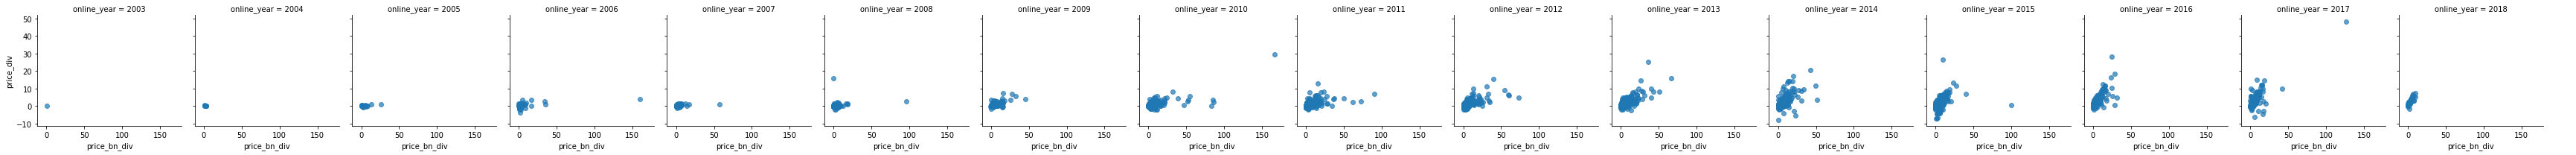

In [14]:
g = sns.FacetGrid(test, col="online_year")
g.map(plt.scatter, "price_bn_div", "price_div", alpha=.7)
g.add_legend();

In [4]:
data = part1.copy()

# 根据款型计算均值
data = data.groupby(['brand_slug','model_slug','model_detail_slug','detail_model','online_year','price_bn'])['price'].median().reset_index().rename(columns={'price':'median_price'})
data = data.sort_values(by=['brand_slug','model_slug','online_year','price_bn'])

# 根据年限,统计指导价差值的价格差
model_year = data.loc[:, ['model_slug', 'online_year']]
model_year = model_year.drop_duplicates(['model_slug', 'online_year']).reset_index(drop=True)

count = 0
result = pd.DataFrame([],columns=['model_slug', 'online_year', 'price_bn_div', 'price_div'])
for model_slug,online_year in model_year.loc[:, ['model_slug','online_year']].values:
    temp = data.loc[(data['model_slug'] == model_slug)&(data['online_year'] == online_year), :].reset_index(drop=True)
    if len(temp) <= 1:
        continue
    for i in range(1,len(temp)):
        price_bn_div = temp.loc[i, 'price_bn'] - temp.loc[0, 'price_bn']
        price_div = temp.loc[i, 'median_price'] - temp.loc[0, 'median_price']
        result.loc[count, ['model_slug', 'online_year', 'price_bn_div', 'price_div']] = [model_slug,online_year,price_bn_div,price_div]
        count = count + 1
# model_year.head()

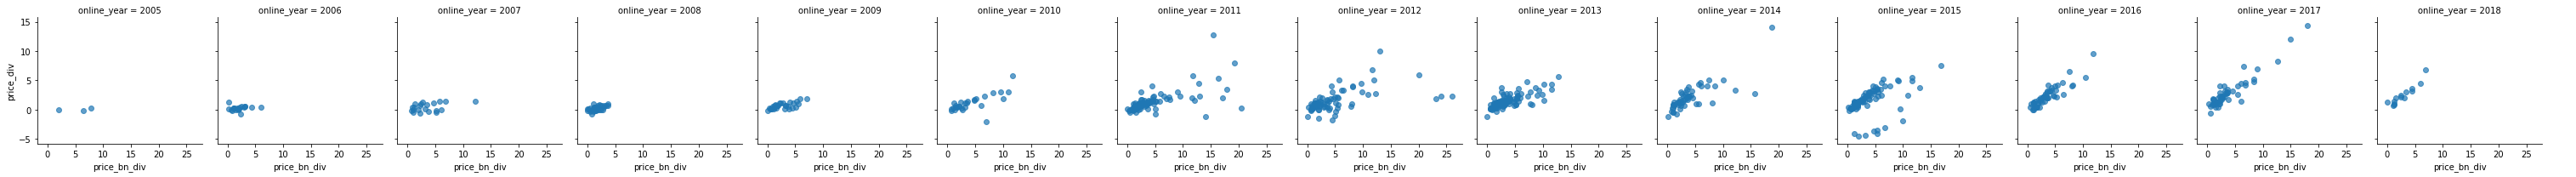

In [5]:
g = sns.FacetGrid(result, col="online_year")
g.map(plt.scatter, "price_bn_div", "price_div", alpha=.7)
g.add_legend();

In [8]:
data = part1.copy()

# 根据款型计算均值
mean_value = data.groupby(['model_detail_slug'])['price'].median().reset_index().rename(columns={'price':'median_value'})
data = data.merge(mean_value, how='left', on=['model_detail_slug'])

data['price_div'] = (data['price'] - data['median_value'])
data.head()

,pub_time,brand_slug,model_slug,model_detail_slug,mile,year,month,province,price,price_bn,brand_name,global_name,detail_model,online_year,volume,control,emission_standard,brand_area,median_value,price_div
0,2018-05-29 00:00:00,dazhong,dazhong-polo,m12650_ba,8.06,2013,3,上海,4.5,9.99,大众,大众POLO,2011款 1.6L 手动 致尚版,2011,1.6,手动,国4,德系,3.8,0.7
1,2018-05-29 00:00:00,dazhong,dazhong-polo,19255_ah,1.99,2014,11,江西,7.0,11.19,大众,大众POLO,2014款 1.6L 自动 舒适版,2014,1.6,自动,国5,德系,6.5,0.5
2,2018-05-29 00:00:00,dazhong,baolai,model_31544_cs,4.26,2013,8,吉林,6.0,10.78,大众,大众宝来,2013款 1.6L 手动 时尚型,2013,1.6,手动,国4,德系,5.6,0.4
3,2018-05-29 00:00:00,dazhong,jetta,m11770_xc,9.90,2012,1,河北,3.9,8.08,大众,大众捷达,2012款 1.6L 手动 典藏版,2012,1.6,手动,国4,德系,3.7,0.2
4,2018-05-29 00:00:00,dazhong,tuguan,m18778_pa,8.97,2011,3,山西,10.5,25.18,大众,大众途观,2010款 1.8TSI 手自一体 两驱菁英版,2010,1.8,自动,国4,德系,10.5,0.0


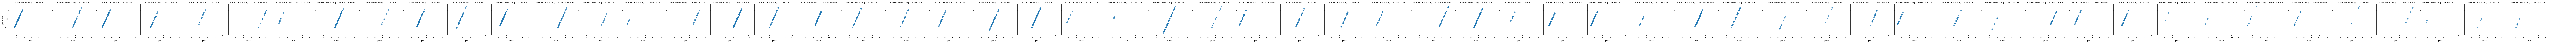

In [9]:
result = data.loc[(data['model_slug'] == 'langyi')&(data['province'] == '江苏'), :]
result.reset_index(inplace=True, drop=True)
g = sns.FacetGrid(result, col="model_detail_slug")
g.map(plt.scatter, "price", "price_div", alpha=.7)
g.add_legend();

In [42]:
data = part1.copy()

# 根据款型计算均值
data = data.groupby(by=['brand_slug','model_slug','model_detail_slug','price_bn', 'online_year','year'])['price'].median().reset_index().rename(columns={'price':'median_value'})
data['warehouse_year'] = data['year'] - data['online_year']

# 根据年限,统计上牌年份的价格差
detail_year = data.loc[:, ['model_detail_slug', 'online_year']]
detail_year = detail_year.drop_duplicates(['model_detail_slug', 'online_year']).reset_index(drop=True)

count = 0
result = pd.DataFrame([],columns=['model_detail_slug','median_value', 'online_year', 'warehouse_year','price_div'])
for model_detail_slug,online_year in detail_year.loc[:, ['model_detail_slug','online_year']].values:
    temp = data.loc[(data['model_detail_slug'] == model_detail_slug)&(data['online_year'] == online_year), :].reset_index(drop=True)
    if (len(temp) <= 1) | (len(temp.loc[(temp['warehouse_year'] == 0), :]) == 0):
        continue
    median_value = temp.loc[(temp['warehouse_year'] == 0), 'median_value'].values[0]
    for i in range(0,len(temp)):
        price_div = temp.loc[i, 'median_value'] - median_value
        warehouse_year = temp.loc[i, 'warehouse_year']
#         median_value = temp.loc[i, 'median_value']
        result.loc[count, ['model_detail_slug','median_value', 'online_year','warehouse_year', 'price_div']] = [model_detail_slug,median_value,online_year,warehouse_year,price_div]
        count = count + 1

# result.head()

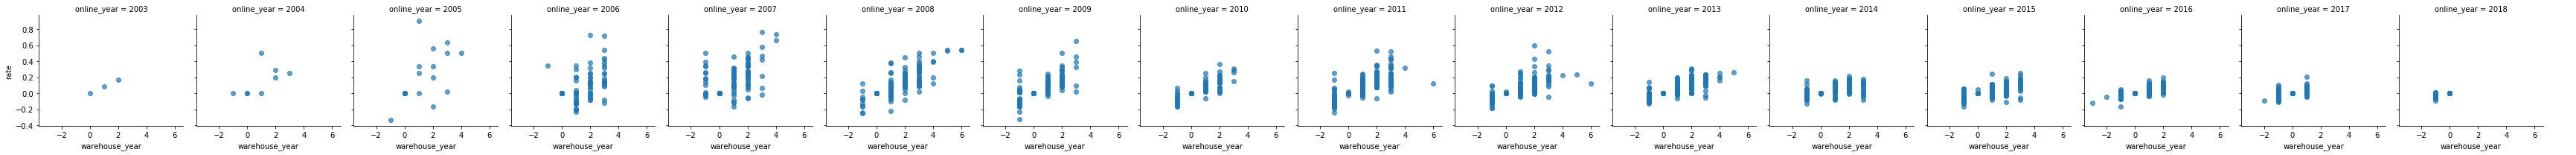

In [44]:
result['rate'] = result['price_div'] / result['median_value']
g = sns.FacetGrid(result, col="online_year")
g.map(plt.scatter, "warehouse_year", "rate", alpha=.7)
g.add_legend();

In [55]:
def cal_use_mile_per_months(df):
    return df['mile'] / ((datetime.datetime.now().year - df['year'])*12 + datetime.datetime.now().month - df['month'])

data = part1.copy()

# 根据款型计算均值
median_value = data.groupby(by=['model_detail_slug','province', 'year'])['price'].median().reset_index().rename(columns={'price':'median_value'})
data = data.merge(median_value, how='left', on=['model_detail_slug','province','year'])
data['mile_per_month'] = data.apply(cal_use_mile_per_months, axis=1)
data['price_div'] = (data['price'] - data['median_value']) / data['median_value']

data.head()

,pub_time,brand_slug,model_slug,model_detail_slug,mile,year,month,province,price,price_bn,...,global_name,detail_model,online_year,volume,control,emission_standard,brand_area,median_value,mile_per_month,price_div
0,2018-05-29 00:00:00,dazhong,dazhong-polo,m12650_ba,8.06,2013,3,上海,4.5,9.99,...,大众POLO,2011款 1.6L 手动 致尚版,2011,1.6,手动,国4,德系,4.35,0.118529,0.034483
1,2018-05-29 00:00:00,dazhong,dazhong-polo,19255_ah,1.99,2014,11,江西,7.0,11.19,...,大众POLO,2014款 1.6L 自动 舒适版,2014,1.6,自动,国5,德系,6.60,0.041458,0.060606
2,2018-05-29 00:00:00,dazhong,baolai,model_31544_cs,4.26,2013,8,吉林,6.0,10.78,...,大众宝来,2013款 1.6L 手动 时尚型,2013,1.6,手动,国4,德系,5.90,0.067619,0.016949
3,2018-05-29 00:00:00,dazhong,jetta,m11770_xc,9.90,2012,1,河北,3.9,8.08,...,大众捷达,2012款 1.6L 手动 典藏版,2012,1.6,手动,国4,德系,3.80,0.120732,0.026316
4,2018-05-29 00:00:00,dazhong,tuguan,m18778_pa,8.97,2011,3,山西,10.5,25.18,...,大众途观,2010款 1.8TSI 手自一体 两驱菁英版,2010,1.8,自动,国4,德系,10.50,0.097500,0.000000


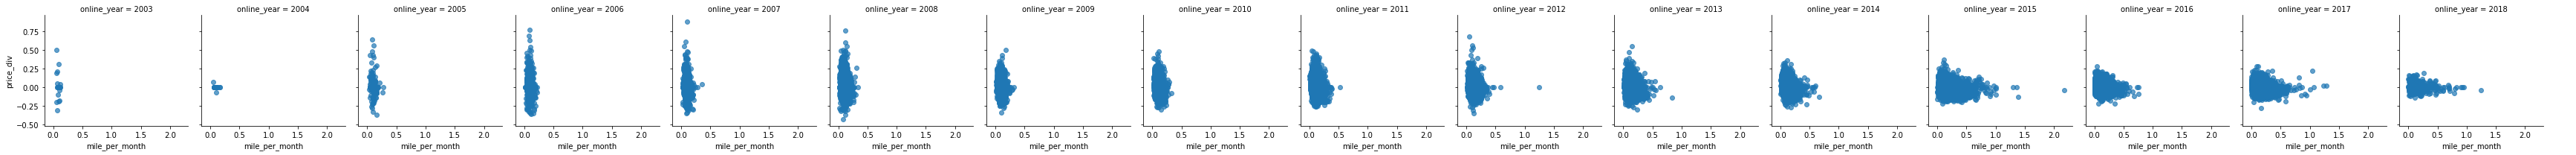

In [56]:
g = sns.FacetGrid(data, col="online_year")
g.map(plt.scatter, "mile_per_month", "price_div", alpha=.7)
g.add_legend();

In [38]:
result.groupby(['model_detail_slug'])['detail_model'].count().reset_index().sort_values(by=['detail_model'])

,model_detail_slug,detail_model
39,26039_autotis,2
41,26059_autotis,2
57,m8814_ba,3
19,13577_ah,3
49,m11222_ba,3
20,13597_ah,4
53,m11766_ba,4
4,100094_autotis,4
52,m11765_ba,4
29,17300_ah,5


,pub_time,brand_slug,model_slug,model_detail_slug,mile,year,month,city,province,price,price_bn,brand_name,global_name,detail_model,online_year,volume,control,emission_standard,brand_area
0,2018-05-29 00:00:00,guangqichengyongche,guangqichuanqiGS4,109252_autotis,2.00,2017,10,长沙,湖南,9.3,13.38,广汽传祺,传祺GS4,2016款 1.5T 双离合 235T 精英版,2016,1.5,自动,国5,国产
1,2018-05-29 00:00:00,hyundai,yilante,m108691_ba,11.18,2009,11,西安,陕西,2.0,11.38,现代,现代伊兰特,2008款 1.6L 自动 优全版,2008,1.6,自动,国4,韩系
2,2018-05-29 00:00:00,changanshangyong,changanoushang,119336_autotis,3.61,2017,7,唐山,河北,5.0,6.59,长安商用,长安欧尚,2017款 1.5L 手动 豪华型,2017,1.5,手动,国5,国产
3,2018-05-29 00:00:00,dazhong,dazhong-polo,m12650_ba,8.06,2013,3,上海,上海,4.5,9.99,大众,大众POLO,2011款 1.6L 手动 致尚版,2011,1.6,手动,国4,德系
4,2018-05-29 00:00:00,dazhong,dazhong-polo,19255_ah,1.99,2014,11,南昌,江西,7.0,11.19,大众,大众POLO,2014款 1.6L 自动 舒适版,2014,1.6,自动,国5,德系
